# Evaluation reports EDA

> IOM Reports Exploratory Data Analysis

## Imports

In [ ]:
import pandas as pd
from evaluatr.readers import load_evals
from pathlib import Path
from fastcore.all import *
from rich import print

from matplotlib import pyplot as plt
import seaborn as sns

## Configs

In [ ]:
path = Path("../../_data/output/evaluations.json")

In [ ]:
load_evals(path).filter(lambda x: "ex-post" in x['meta']['Title'].lower())

(#731) [{'id': '1a57974ab89d7280988aa6b706147ce1', 'docs': [{'Document Subtype': 'Evaluation report', 'File URL': 'https://evaluation.iom.int/sites/g/files/tmzbdl151/files/docs/resources/Internal%20Evaluation_NG20P0516_MAY_2023_FINAL_Abderrahim%20EL%20MOULAT.pdf', 'File description': 'Evaluation Report'}, {'Document Subtype': 'Evaluation brief', 'File URL': 'https://evaluation.iom.int/sites/g/files/tmzbdl151/files/docs/resources/RR0163_Evaluation%20Brief_MAY_%202023_Abderrahim%20EL%20MOULAT.pdf', 'File description': 'Evaluation Brief'}], 'meta': {'Title': 'EX-POST EVALUATION OF THE PROJECT:  NIGERIA: STRENGTHENING REINTEGRATION FOR RETURNEES (SRARP)  - PHASE II', 'Year': 2023, 'Author': 'Abderrahim El Moulat', 'Best Practicesor Lessons Learnt': 'Yes', 'Date of Publication': '2023-05-10', 'Donor': 'Government of Germany', 'Evaluation Brief': 'Yes', 'Evaluation Commissioner': 'Donor, IOM', 'Evaluation Coverage': 'Country', 'Evaluation Period From Date': 'nan', 'Evaluation Period To Date'

## Accessing evaluation report

### By ID

In [ ]:
#| eval: false
idx = '9558482be1b049827f630c1760025c0f'
[o for o in load_evals(path).filter(lambda x: x['id'] == idx)]

[{'id': '9558482be1b049827f630c1760025c0f',
  'docs': [{'Document Subtype': 'Evaluation brief',
    'File URL': 'https://evaluation.iom.int/sites/g/files/tmzbdl151/files/docs/resources/IOM-CREST%20Evaluation-Brief-D3_Thi%20Bao%20Chau%20NGUYEN.pdf',
    'File description': 'Evaluation Brief'},
   {'Document Subtype': 'Annexes',
    'File URL': 'https://evaluation.iom.int/sites/g/files/tmzbdl151/files/docs/resources/IOM-CREST%20Evaluation-D3_Thi%20Bao%20Chau%20NGUYEN.pdf',
    'File description': 'Terms of Reference'},
   {'Document Subtype': 'Evaluation report',
    'File URL': 'https://evaluation.iom.int/sites/g/files/tmzbdl151/files/docs/resources/Management%20Response_March%202024%20%281%29.docx',
    'File description': 'Evaluation Report'},
   {'Document Subtype': 'Management response',
    'File URL': 'https://evaluation.iom.int/sites/g/files/tmzbdl151/files/docs/resources/ToR_Final%20Evaluation_CREST_Thi%20Bao%20Chau%20NGUYEN.pdf',
    'File description': 'Management Response'}],

### By Title

In [ ]:
#| eval: false
title = 'sri lanka'
[o for o in load_evals(path).filter(lambda x: title in x['meta']['Title'].lower())]

[{'id': '63fd76e7476d6fcccd9856e38916d425',
  'docs': [{'Document Subtype': 'Evaluation report',
    'File URL': 'https://evaluation.iom.int/sites/g/files/tmzbdl151/files/docs/resources/IDF%2520Support%2520Global%2520Consultation%2520Migrant%2520Health%2520Sri%2520Lanka%25202019.pdf',
    'File description': 'IDF Support Global Consultation Migrant Health Sri Lanka 2019.pdf'}],
  'meta': {'Title': 'TECHNICAL SUPPORT TO GLOBAL CONSULTATION ON MIGRANT HEALTH – SRI LANKA',
   'Year': 2018,
   'Author': 'Dr. Aimee Lee',
   'Best Practicesor Lessons Learnt': 'Yes',
   'Date of Publication': '2018-10-19',
   'Donor': 'IOM Development Fund',
   'Evaluation Brief': 'No',
   'Evaluation Commissioner': 'IOM',
   'Evaluation Coverage': 'Country',
   'Evaluation Period From Date': '2016-10-01 00:00:00',
   'Evaluation Period To Date': '2017-09-30',
   'Executive Summary': 'Yes',
   'External Version of the Report': 'No',
   'Languages': 'English',
   'Migration Thematic Areas': 'Migration health (

## Counts & Bar Charts per type

In [ ]:
import pandas as pd
import json
from pathlib import Path

def create_evaluation_dataframes(json_path):
    """
    Create multiple DataFrames optimized for different types of analysis
    """
    
    with open(json_path) as f:
        evals = json.load(f)
    
    # Main DataFrame (evaluation level)
    eval_records = []
    for eval_record in evals:
        record = {'id': eval_record['id']}
        
        # Flatten metadata, handling both lists and strings
        for key, value in eval_record['meta'].items():
            if isinstance(value, list):
                record[f"{key}_count"] = len(value)
                record[f"{key}_concatenated"] = '; '.join(value) if value else None
                record[key] = value  # Keep original list for reference
            elif isinstance(value, str) and ',' in value and key in ['Migration Thematic Areas', 'Relevant Crosscutting Themes']:
                # Handle comma-separated strings as if they were lists
                items = [item.strip() for item in value.split(',') if item.strip()]
                record[f"{key}_count"] = len(items)
                record[f"{key}_concatenated"] = value
                record[key] = items  # Convert to list for consistency
            else:
                record[key] = value
        
        record['doc_count'] = len(eval_record['docs'])
        eval_records.append(record)
    
    df_main = pd.DataFrame(eval_records)
    
    # Exploded DataFrames for multi-valued fields
    exploded_dfs = {}
    list_fields = ['Countries Covered', 'Migration Thematic Areas', 'Relevant Crosscutting Themes']
    
    for field in list_fields:
        if field in df_main.columns:
            # Use the list version we created above
            temp_df = df_main[['id', field]].copy()
            temp_df = temp_df.dropna()
            
            if len(temp_df) > 0:
                # Explode the list column
                exploded = temp_df.explode(field)
                exploded[field] = exploded[field].str.strip()
                exploded_dfs[field] = exploded[['id', field]]
    
    # Documents DataFrame
    doc_records = []
    for eval_record in evals:
        eval_id = eval_record['id']
        meta = eval_record['meta']
        
        for doc in eval_record['docs']:
            doc_record = {
                'eval_id': eval_id,
                'title': meta.get('Title'),
                'year': meta.get('Year'),
                'author': meta.get('Author'),
                'donor': meta.get('Donor'),
                'doc_subtype': doc['Document Subtype'],
                'file_url': doc['File URL'],
                'file_description': doc['File description']
            }
            doc_records.append(doc_record)
    
    df_docs = pd.DataFrame(doc_records)
    
    return {
        'main': df_main,
        'documents': df_docs,
        'exploded': exploded_dfs
    }

In [ ]:
path = Path("../../_data/output/evaluations.json")
dataframes = create_evaluation_dataframes(path)

# Access different DataFrames
df_main = dataframes['main']
df_docs = dataframes['documents']
df_countries = dataframes['exploded']['Countries Covered']
df_themes = dataframes['exploded']['Migration Thematic Areas']

print("Main DataFrame:", df_main.shape)
print("Documents DataFrame:", df_docs.shape)
print("Countries DataFrame:", df_countries.shape)
print("Themes DataFrame:", df_themes.shape)

Main DataFrame:
(731, 44)

Documents DataFrame:
(1405, 8)

Countries DataFrame:
(1491, 2)

Themes DataFrame:
(1948, 2)

In [ ]:
df_main.head()

,id,Title,Year,Author,Best Practicesor Lessons Learnt,Date of Publication,Donor,Evaluation Brief,Evaluation Commissioner,Evaluation Coverage,...,Level of Evaluation,Document Subtype,File URL,File description,Management response,Date added,Metaevaluation,exclude,reason,doc_count
0,1a57974ab89d7280988aa6b706147ce1,EX-POST EVALUATION OF THE PROJECT: NIGERIA: S...,2023,Abderrahim El Moulat,Yes,2023-05-10,Government of Germany,Yes,"Donor, IOM",Country,...,Decentralized,"Evaluation report, Evaluation brief",https://evaluation.iom.int/sites/g/files/tmzbd...,"Evaluation Report , Evaluation Brief",No,"Fri, 07/07/2023 - 15:35",2020-24,NaN,NaN,2
1,c660e774d14854e20dc74457712b50ec,FINAL EVALUATION OF THE PROJECT: STRENGTHEN BO...,2023,Abderrahim El Moulat,Yes,2023-02-14,Government of Canada,Yes,"Donor, IOM",Multi-country,...,Decentralized,"Evaluation report, Evaluation brief",https://evaluation.iom.int/sites/g/files/tmzbd...,"Evaluation Report , Evaluation Brief",No,"Fri, 05/19/2023 - 16:49",2020-24,NaN,NaN,2
2,2cae361c6779b561af07200e3d4e4051,"Final Evaluation of the project ""SUPPORTING TH...",2022,Abderrahim El Moulat,Yes,2022-09-15,IOM Development Fund,Yes,IOM,Country,...,Decentralized,"Evaluation report, Evaluation brief",https://evaluation.iom.int/sites/g/files/tmzbd...,"Evaluation Report , Evaluation Brief",No,"Thu, 02/23/2023 - 11:43",2020-24,NaN,NaN,2
3,a9dea21fd254df7759b3936903e0a885,Finale Internal Evluation: ENHANCING THE CAPAC...,2022,Abderrahim El Moulat,Yes,2022-06-22,IOM Development Fund,Yes,"Donor, IOM",Country,...,Decentralized,"Evaluation brief, Evaluation report",https://evaluation.iom.int/sites/g/files/tmzbd...,"Evaluation brief , Evaluation Report",No,"Mon, 08/08/2022 - 11:37",2020-24,NaN,NaN,2
4,f0b09b92ea8ad6dddd9623de68a8d278,"Evaluation Finale Interne du Projet ""ENGAGEMEN...",2022,Abderrahim El Moulat,Yes,2022-05-17,IOM Development Fund,Yes,"Donor, IOM",Country,...,Decentralized,"Evaluation brief, Evaluation report",https://evaluation.iom.int/sites/g/files/tmzbd...,"Evaluation Brief, Evaluation Report",No,"Fri, 08/05/2022 - 15:00",2020-24,NaN,NaN,2


In [ ]:
df_docs.head()

,eval_id,title,year,author,donor,doc_subtype,file_url,file_description
0,1a57974ab89d7280988aa6b706147ce1,EX-POST EVALUATION OF THE PROJECT: NIGERIA: S...,2023,Abderrahim El Moulat,Government of Germany,Evaluation report,https://evaluation.iom.int/sites/g/files/tmzbd...,Evaluation Report
1,1a57974ab89d7280988aa6b706147ce1,EX-POST EVALUATION OF THE PROJECT: NIGERIA: S...,2023,Abderrahim El Moulat,Government of Germany,Evaluation brief,https://evaluation.iom.int/sites/g/files/tmzbd...,Evaluation Brief
2,c660e774d14854e20dc74457712b50ec,FINAL EVALUATION OF THE PROJECT: STRENGTHEN BO...,2023,Abderrahim El Moulat,Government of Canada,Evaluation report,https://evaluation.iom.int/sites/g/files/tmzbd...,Evaluation Report
3,c660e774d14854e20dc74457712b50ec,FINAL EVALUATION OF THE PROJECT: STRENGTHEN BO...,2023,Abderrahim El Moulat,Government of Canada,Evaluation brief,https://evaluation.iom.int/sites/g/files/tmzbd...,Evaluation Brief
4,2cae361c6779b561af07200e3d4e4051,"Final Evaluation of the project ""SUPPORTING TH...",2022,Abderrahim El Moulat,IOM Development Fund,Evaluation report,https://evaluation.iom.int/sites/g/files/tmzbd...,Evaluation Report


In [ ]:
df_countries.head()

,id,Countries Covered
0,1a57974ab89d7280988aa6b706147ce1,Nigeria
1,c660e774d14854e20dc74457712b50ec,Mali
1,c660e774d14854e20dc74457712b50ec,Niger
2,2cae361c6779b561af07200e3d4e4051,Cabo Verde
3,a9dea21fd254df7759b3936903e0a885,Senegal


In [ ]:
df_countries.groupby('id').size().sort_values(ascending=False)

id
1eafa00d143cec4b2067c938cd0665ad    18
9558482be1b049827f630c1760025c0f    16
2aacaf6d93836e795bb78009c30fdcfb    13
f6d27662a2d9ac51c9212a03615b5bd7    12
8d6171c5252c8b5f537c8f22d6df7b61    12
                                    ..
6b30198a6f8b83c8cbf36ef7d9e8cb29     1
6ba7723382db006326abd2d12db64380     1
6bb4ac298da9a2e13fd85836bfa70a18     1
6c20c87993c52eac06f6c9c20d193041     1
ffa7846d8ad478ed9fa22411e39fc685     1
Length: 731, dtype: int64

### Migration Thematic Areas

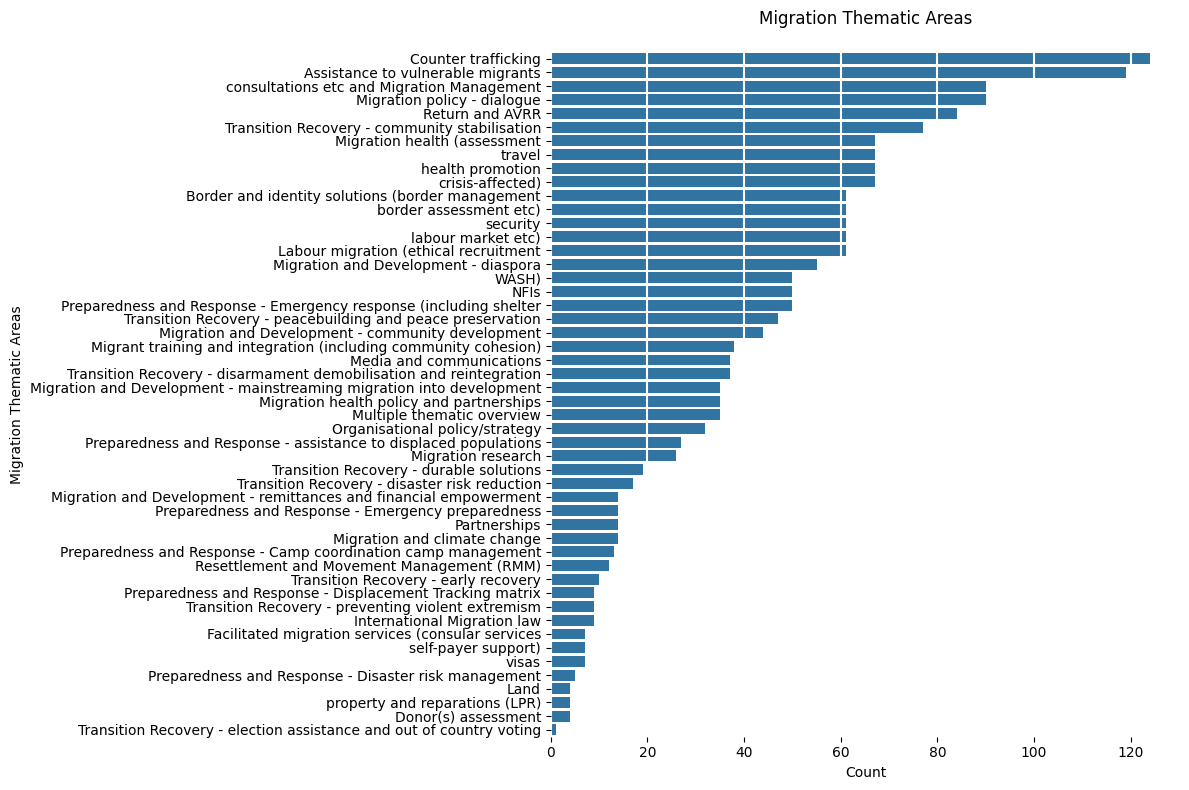

In [ ]:
theme_counts = df_themes.groupby('Migration Thematic Areas').size().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=theme_counts.values, y=theme_counts.index, orient='h')
plt.grid(axis='x', color='white', lw=1.5)
plt.box(False)
plt.title('Migration Thematic Areas', pad=20)
plt.xlabel('Count')
plt.tight_layout()

### Cross-cutting Themes

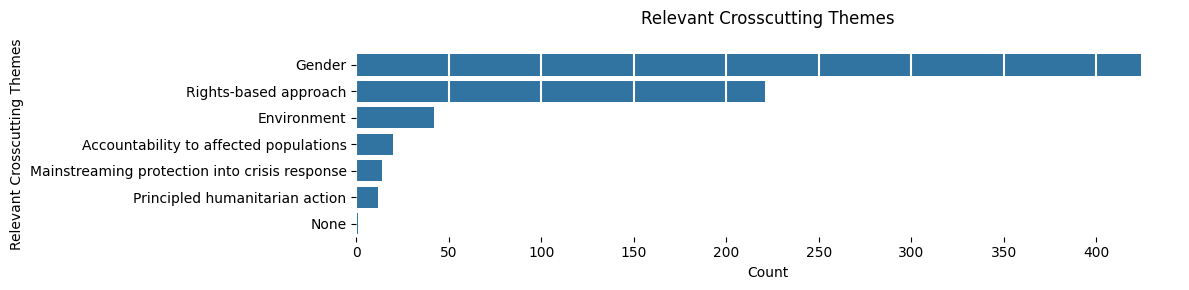

In [ ]:
df_crosscutting = dataframes['exploded']['Relevant Crosscutting Themes']
theme_counts = df_crosscutting.groupby('Relevant Crosscutting Themes').size().sort_values(ascending=False)

plt.figure(figsize=(12, 3))
sns.barplot(x=theme_counts.values, y=theme_counts.index, orient='h')
plt.grid(axis='x', color='white', lw=1.5)
plt.box(False)
plt.title('Relevant Crosscutting Themes', pad=20)
plt.xlabel('Count')
plt.tight_layout()

### Year

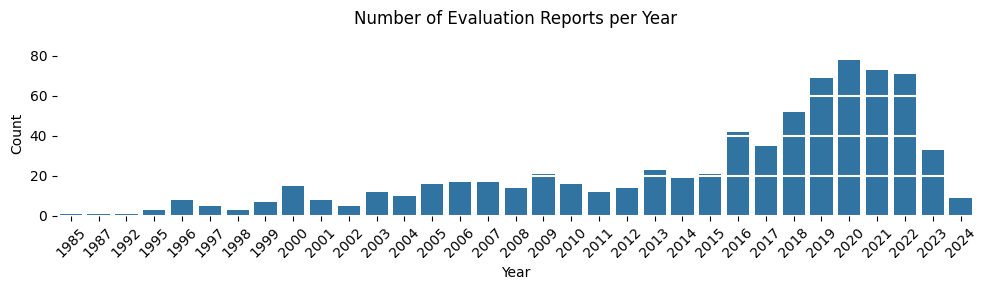

In [ ]:
# Count reports per year
year_counts = df_main['Year'].value_counts().sort_index()

plt.figure(figsize=(10, 3))
sns.barplot(x=year_counts.index, y=year_counts.values)
plt.grid(axis='y', color='white', lw=1.5)
plt.box(False)
plt.title('Number of Evaluation Reports per Year', pad=20)
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

### IOM Regional Office

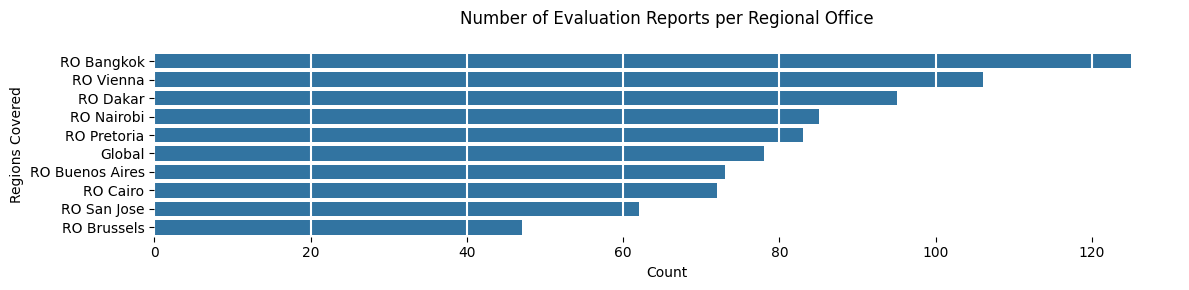

In [ ]:
regional_offices = df_main['Regions Covered'].str.split(r',\s*').explode()

# Count reports per regional office
ro_counts = regional_offices.value_counts()

plt.figure(figsize=(12, 3))
sns.barplot(x=ro_counts.values, y=ro_counts.index, orient='h')
plt.grid(axis='x', color='white', lw=1.5)
plt.box(False)
plt.title('Number of Evaluation Reports per Regional Office', pad=20)
plt.xlabel('Count')
plt.tight_layout()

### Country covered

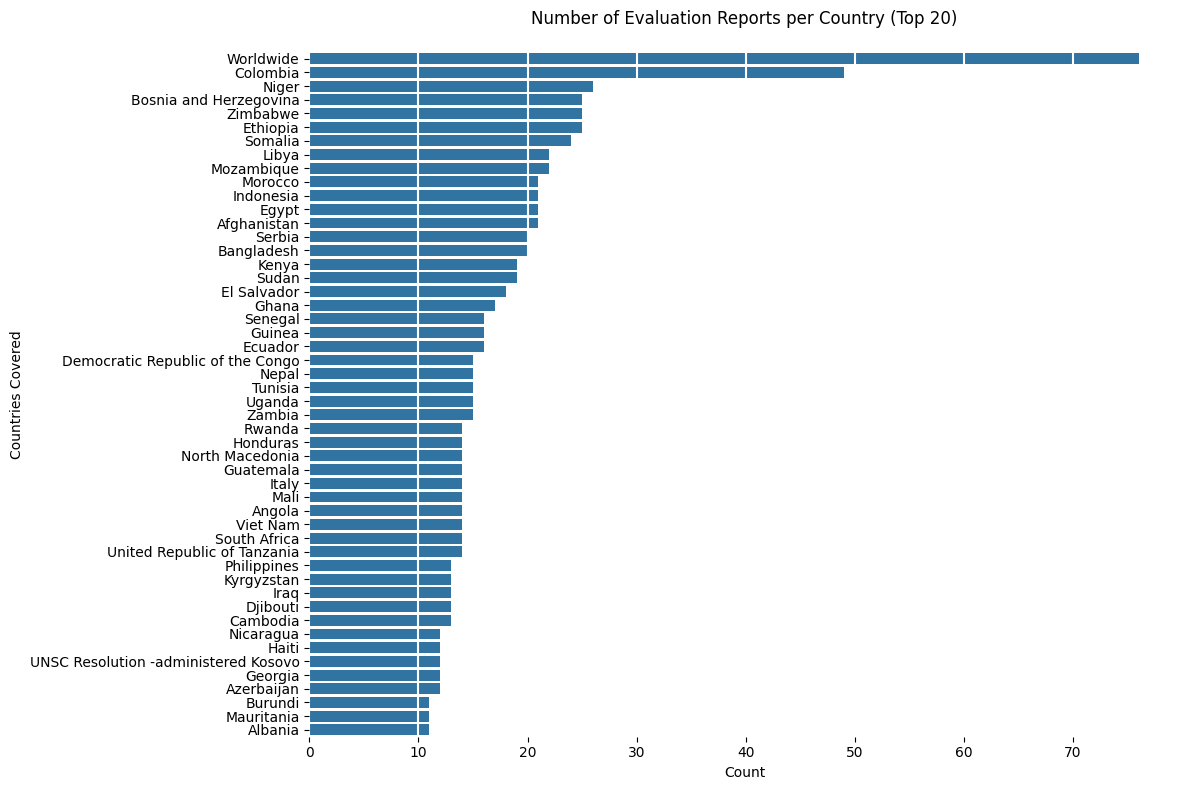

In [ ]:
country_counts = df_countries.groupby('Countries Covered').size().sort_values(ascending=False)
top_20_countries = country_counts.head(50)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_20_countries.values, y=top_20_countries.index, orient='h')
plt.grid(axis='x', color='white', lw=1.5)
plt.box(False)
plt.title('Number of Evaluation Reports per Country (Top 20)', pad=20)
plt.xlabel('Count')
plt.tight_layout()

### Evaluation brief available?

In [ ]:
# Calculate percentage of reports with Evaluation Brief
has_brief = df_main['Evaluation Brief'] == 'Yes'
brief_percentage = (has_brief.sum() / len(df_main)) * 100
print(f"% of reports with Evaluation Brief: {brief_percentage:.1f}% ({has_brief.sum()} out of {len(df_main)} total reports)")

% of reports with Evaluation Brief: 32.7% (239 out of 731 total reports)

### Type of Evaluation Scope

In [ ]:
df_main['Type of Evaluation Scope'].value_counts()

Type of Evaluation Scope
Programme/Project                      633
Thematic                                27
Programme/Project, Thematic             13
Strategy                                10
Synthesis                                9
Strategy, Thematic                       7
Programme/Project, Strategy              4
Thematic, Strategy                       3
Policy                                   3
Thematic, Programme/Project              3
Policy, Thematic                         2
Strategy, Programme/Project              2
Programme/Project, Synthesis             2
Thematic, Synthesis                      1
Policy, Strategy                         1
Strategy, Policy                         1
Policy, Programme/Project, Strategy      1
Thematic, Policy                         1
Policy, Programme/Project                1
Programme/Project, Thematic, Policy      1
Name: count, dtype: int64

### Type of Evaluation Timing (%)

In [ ]:
df_main['Type of Evaluation Timing'].value_counts(normalize=True).mul(100).round(1)

Type of Evaluation Timing
Final (at the end of the project/programme)                 47.7
Ex-post (after the end of the project/programme)            20.2
Mid-term (during the project's implementation/programme)    19.0
Not applicable                                               9.8
Not available                                                2.1
Real-time (at the early stages of project/programme)         0.8
Ex-ante (before the start of a project/programme)            0.4
Name: proportion, dtype: float64

### Type of Evaluator (%)

In [ ]:
df_main['Type of Evaluator'].value_counts(normalize=True).mul(100).round(1)

Type of Evaluator
External                             62.8
Internal                             25.5
Central/OIG                          10.0
Mixed (Internal/OIG and external)     1.6
Name: proportion, dtype: float64

### Level of Evaluation (%)

In [ ]:
df_main['Level of Evaluation'].value_counts(normalize=True).mul(100).round(1)

Level of Evaluation
Decentralized    86.6
Centralized      10.8
Other             2.6
Name: proportion, dtype: float64